Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [174]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [175]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (187473, 28, 28) (187473,)
Validation set (9867, 28, 28) (9867,)
Test set (9788, 28, 28) (9788,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [176]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (187473, 784) (187473, 10)
Validation set (9867, 784) (9867, 10)
Test set (9788, 784) (9788, 10)


In [177]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [178]:
# compute the logits for the given inputs and the layers
def calc_logits(dataset, *layers, dropouts=False):
    # variable for the current layer
    activations = dataset
    # apply each layer to the previous outputs
    for i, layer in enumerate(layers):
        activations = tf.matmul(activations, layer[0]) + layer[1]
        # run a ReLU in between each layer, but not on the final layer
        if i < len(layers) - 1:
            activations = tf.nn.relu(activations)
            if dropouts:
                activations = tf.nn.dropout(activations, 0.5)
    return activations

# define tf variables for the NN layers given the sizes of the layers
def construct_layers(*sizes):
    layers = []
    for i in range(1, len(sizes)):
        # initialize weights. stddev must be chosen carefully to avoid neuron saturation
        weights = tf.Variable(
            tf.truncated_normal(
                [sizes[i - 1], sizes[i]],
                stddev=np.sqrt(2.0 / sizes[i - 1])))
        biases = tf.Variable(tf.zeros([sizes[i]]))
        layers.append([weights, biases])
    return layers
    

In [179]:
batch_size = 128
learning_rate = 0.5

regress_graph = tf.Graph()
with regress_graph.as_default():
    # add the data to the tensorflow graph
    tf_train_dataset = tf.placeholder(
        tf.float32,
        shape=(batch_size, image_size ** 2))
    tf_train_labels = tf.placeholder(
        tf.float32,
        shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    regul_coeff = tf.placeholder(tf.float32)
    
    # declare the weights and biases
    weights = tf.Variable(
        tf.truncated_normal([image_size ** 2, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # run the math and calculate the error
    logits = calc_logits(tf_train_dataset, [weights, biases])
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    # add regularization term to the error
    loss += regul_coeff * tf.nn.l2_loss(weights)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(calc_logits(tf_valid_dataset, [weights, biases]))
    test_prediction = tf.nn.softmax(calc_logits(tf_test_dataset, [weights, biases]))
    

CPU times: user 1min 46s, sys: 21.5 s, total: 2min 7s
Wall time: 1min 25s


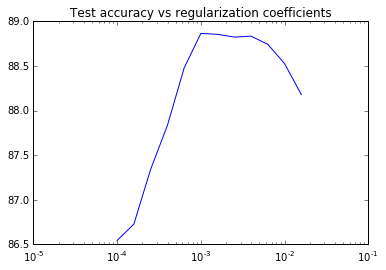

In [180]:
def run_regress(num_steps, regul_coeff_val, verbose=False):
    with tf.Session(graph=regress_graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            # calculate the starting index for the next batch
            offset = (step * batch_size) % (len(train_labels) - batch_size)
            # get next batch for this iteration of stochastic gradient descent
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            data = {
                tf_train_dataset: batch_data,
                tf_train_labels: batch_labels,
                regul_coeff: regul_coeff_val }
            
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction],
                feed_dict=data)
            
            # report on the progress
            if verbose and step % (num_steps // 10) == 0:
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
        
        return accuracy(test_prediction.eval(), test_labels)

# test several different regulariztion terms
regul_coeffs = np.power(10, np.arange(-4, -1.7, 0.2), dtype=np.float32)
%time accuracy_vals = [run_regress(3001, regul_coeff) for regul_coeff in regul_coeffs]
plt.semilogx(regul_coeffs, accuracy_vals)
plt.title('Test accuracy vs regularization coefficients')
plt.show()

In [181]:
print('Optimal regularization parameter:')
optimal_regul = regul_coeffs[np.argmax(accuracy_vals)]
print(optimal_regul)

%time run_regress(3001,  optimal_regul, verbose=True)

Optimal regularization parameter:
0.001
Minibatch loss at step 0: 24.333015
Minibatch accuracy: 10.2%
Validation accuracy: 12.2%
Minibatch loss at step 300: 3.542153
Minibatch accuracy: 75.8%
Validation accuracy: 75.1%
Minibatch loss at step 600: 2.869265
Minibatch accuracy: 69.5%
Validation accuracy: 76.1%
Minibatch loss at step 900: 2.005164
Minibatch accuracy: 78.1%
Validation accuracy: 78.5%
Minibatch loss at step 1200: 1.657538
Minibatch accuracy: 78.9%
Validation accuracy: 79.2%
Minibatch loss at step 1500: 1.028831
Minibatch accuracy: 85.9%
Validation accuracy: 80.0%
Minibatch loss at step 1800: 1.211218
Minibatch accuracy: 81.2%
Validation accuracy: 81.3%
Minibatch loss at step 2100: 1.100792
Minibatch accuracy: 75.8%
Validation accuracy: 81.0%
Minibatch loss at step 2400: 0.776256
Minibatch accuracy: 83.6%
Validation accuracy: 81.1%
Minibatch loss at step 2700: 0.822515
Minibatch accuracy: 80.5%
Validation accuracy: 81.8%
Minibatch loss at step 3000: 1.015545
Minibatch accurac

88.782182263996731

In [192]:
batch_size = 128
num_hidden_nodes = 1024
learning_rate = 0.5

nn_graph = tf.Graph()
with nn_graph.as_default():
    tf_train_dataset = tf.placeholder(
        tf.float32,
        shape=(batch_size, image_size ** 2))
    tf_train_labels = tf.placeholder(
        tf.float32,
        shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    regul_coeff = tf.placeholder(tf.float32)
    

    layers = construct_layers(image_size ** 2, num_hidden_nodes, num_labels)
    
    logits = calc_logits(tf_train_dataset, *layers)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    loss += regul_coeff * (tf.nn.l2_loss(layers[0][0]) + tf.nn.l2_loss(layers[1][0]))
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(calc_logits(tf_valid_dataset, *layers))
    test_prediction = tf.nn.softmax(calc_logits(tf_test_dataset, *layers))

In [ ]:
def run_nn(num_steps, regul_coeff_val, verbose=False):
    with tf.Session(graph=nn_graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (len(train_labels) - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            data = {
                tf_train_dataset: batch_data,
                tf_train_labels: batch_labels,
                regul_coeff: regul_coeff_val }
        
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction],
                feed_dict=data)
            
            if verbose and step % (num_steps // 10) == 0:
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
                
        return accuracy(test_prediction.eval(), test_labels)
  

regul_coeffs = np.power(10, np.arange(-4.8, -2.0, 0.2), dtype=np.float32)
%time accuracy_vals = [run_nn(1001, regul_coeff) for regul_coeff in regul_coeffs]
plt.semilogx(regul_coeffs, accuracy_vals)
plt.title('Test accuracy vs regularization coefficients')
plt.show()

In [184]:
print('Optimal regularization parameter:')
optimal_regul = regul_coeffs[np.argmax(accuracy_vals)]
print(optimal_regul)

%time run_nn(1001,  optimal_regul, verbose=True)

Optimal regularization parameter:
0.000398107
Minibatch loss at step 0: 2.722213
Minibatch accuracy: 8.6%
Validation accuracy: 42.4%
Minibatch loss at step 100: 0.784347
Minibatch accuracy: 85.9%
Validation accuracy: 82.2%
Minibatch loss at step 200: 0.887314
Minibatch accuracy: 84.4%
Validation accuracy: 84.6%
Minibatch loss at step 300: 0.824271
Minibatch accuracy: 83.6%
Validation accuracy: 84.7%
Minibatch loss at step 400: 0.814958
Minibatch accuracy: 83.6%
Validation accuracy: 85.4%
Minibatch loss at step 500: 0.701326
Minibatch accuracy: 85.9%
Validation accuracy: 86.0%
Minibatch loss at step 600: 0.877330
Minibatch accuracy: 82.0%
Validation accuracy: 85.9%
Minibatch loss at step 700: 0.717140
Minibatch accuracy: 83.6%
Validation accuracy: 86.8%
Minibatch loss at step 800: 0.635151
Minibatch accuracy: 86.7%
Validation accuracy: 86.8%
Minibatch loss at step 900: 0.730562
Minibatch accuracy: 84.4%
Validation accuracy: 87.1%
Minibatch loss at step 1000: 0.611371
Minibatch accuracy:

92.817736003269303

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [185]:
def run_overfit(num_steps, regul_coeff_val, num_batches, verbose=False):
    with tf.Session(graph=nn_graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            offset = step % num_batches
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            data = {
                tf_train_dataset: batch_data,
                tf_train_labels: batch_labels,
                regul_coeff: regul_coeff_val }
        
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction],
                feed_dict=data)
            
            if verbose and step % (num_steps // 10) == 0:
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
                
        return accuracy(test_prediction.eval(), test_labels)
  

%time run_overfit(501, 0, 3, verbose=True)

Minibatch loss at step 0: 2.367433
Minibatch accuracy: 8.6%
Validation accuracy: 37.9%
Minibatch loss at step 50: 0.015061
Minibatch accuracy: 100.0%
Validation accuracy: 69.6%
Minibatch loss at step 100: 0.006539
Minibatch accuracy: 100.0%
Validation accuracy: 69.7%
Minibatch loss at step 150: 0.004131
Minibatch accuracy: 100.0%
Validation accuracy: 69.8%
Minibatch loss at step 200: 0.002866
Minibatch accuracy: 100.0%
Validation accuracy: 69.8%
Minibatch loss at step 250: 0.002226
Minibatch accuracy: 100.0%
Validation accuracy: 69.8%
Minibatch loss at step 300: 0.001842
Minibatch accuracy: 100.0%
Validation accuracy: 69.8%
Minibatch loss at step 350: 0.001503
Minibatch accuracy: 100.0%
Validation accuracy: 69.8%
Minibatch loss at step 400: 0.001297
Minibatch accuracy: 100.0%
Validation accuracy: 69.9%
Minibatch loss at step 450: 0.001157
Minibatch accuracy: 100.0%
Validation accuracy: 69.9%
Minibatch loss at step 500: 0.001001
Minibatch accuracy: 100.0%
Validation accuracy: 69.9%
CPU 

76.726604004903962

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [186]:
batch_size = 128
num_hidden_nodes = 1024
learning_rate = 0.5

dropouts_graph = tf.Graph()
with dropouts_graph.as_default():
    tf_train_dataset = tf.placeholder(
        tf.float32,
        shape=(batch_size, image_size ** 2))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    layers = construct_layers(image_size ** 2, num_hidden_nodes, num_labels)
    
    logits = calc_logits(tf_train_dataset, *layers, dropouts=True)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(calc_logits(tf_valid_dataset, *layers))
    test_prediction = tf.nn.softmax(calc_logits(tf_test_dataset, *layers))

In [187]:
def run_knockout_nn(num_steps, verbose=False):
    with tf.Session(graph=dropouts_graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (len(train_labels) - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            data = {
                tf_train_dataset: batch_data,
                tf_train_labels: batch_labels }
        
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction],
                feed_dict=data)
            
            if verbose and step % (num_steps // 10) == 0:
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
                
        return accuracy(test_prediction.eval(), test_labels)
  

%time run_knockout_nn(3001, verbose=True)

Minibatch loss at step 0: 2.529994
Minibatch accuracy: 10.2%
Validation accuracy: 38.1%
Minibatch loss at step 300: 0.651115
Minibatch accuracy: 81.2%
Validation accuracy: 83.8%
Minibatch loss at step 600: 0.672698
Minibatch accuracy: 81.2%
Validation accuracy: 85.6%
Minibatch loss at step 900: 0.549887
Minibatch accuracy: 83.6%
Validation accuracy: 86.0%
Minibatch loss at step 1200: 0.608670
Minibatch accuracy: 82.8%
Validation accuracy: 86.8%
Minibatch loss at step 1500: 0.358303
Minibatch accuracy: 88.3%
Validation accuracy: 86.8%
Minibatch loss at step 1800: 0.526905
Minibatch accuracy: 87.5%
Validation accuracy: 87.3%
Minibatch loss at step 2100: 0.646354
Minibatch accuracy: 80.5%
Validation accuracy: 87.7%
Minibatch loss at step 2400: 0.441141
Minibatch accuracy: 89.1%
Validation accuracy: 87.2%
Minibatch loss at step 2700: 0.572631
Minibatch accuracy: 85.2%
Validation accuracy: 87.2%
Minibatch loss at step 3000: 0.651024
Minibatch accuracy: 80.5%
Validation accuracy: 88.0%
CPU t

93.46138128320392

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [188]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 512
num_hidden_nodes3 = 256

deep_graph = tf.Graph()
with deep_graph.as_default():
    tf_train_dataset = tf.placeholder(
        tf.float32,
        shape=(batch_size, image_size ** 2))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)
    
    layers = construct_layers(
        image_size ** 2,
        num_hidden_nodes1,
        num_hidden_nodes2,
        num_hidden_nodes3,
        num_labels)

    logits = calc_logits(tf_train_dataset, *layers)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(calc_logits(tf_valid_dataset, *layers))
    test_prediction = tf.nn.softmax(calc_logits(tf_test_dataset, *layers))

In [189]:
def run_deep(num_steps):
    with tf.Session(graph=deep_graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (len(train_labels) - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            data = {
                tf_train_dataset: batch_data,
                tf_train_labels: batch_labels }
        
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=data)
        
            if step % (num_steps // 10) == 0:
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
                
        return accuracy(test_prediction.eval(), test_labels)
    
%time run_deep(5001)

Minibatch loss at step 0: 2.327041
Minibatch accuracy: 10.9%
Validation accuracy: 33.7%
Minibatch loss at step 500: 0.342179
Minibatch accuracy: 90.6%
Validation accuracy: 87.0%
Minibatch loss at step 1000: 0.322500
Minibatch accuracy: 89.1%
Validation accuracy: 87.2%
Minibatch loss at step 1500: 0.212072
Minibatch accuracy: 93.8%
Validation accuracy: 88.5%
Minibatch loss at step 2000: 0.205471
Minibatch accuracy: 94.5%
Validation accuracy: 89.8%
Minibatch loss at step 2500: 0.234393
Minibatch accuracy: 92.2%
Validation accuracy: 89.9%
Minibatch loss at step 3000: 0.427662
Minibatch accuracy: 88.3%
Validation accuracy: 89.9%
Minibatch loss at step 3500: 0.192685
Minibatch accuracy: 94.5%
Validation accuracy: 90.1%
Minibatch loss at step 4000: 0.198824
Minibatch accuracy: 93.0%
Validation accuracy: 90.6%
Minibatch loss at step 4500: 0.219865
Minibatch accuracy: 93.0%
Validation accuracy: 90.7%
Minibatch loss at step 5000: 0.223745
Minibatch accuracy: 93.0%
Validation accuracy: 90.8%
CPU

95.647731916632608